[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/Data_visualization.ipynb)

<b>IMPORTANT</b>: In order to access our files stored in Google Drive, you need to visit the following link: https://drive.google.com/drive/folders/1Qfr8TNZSlrhpKgYx0LrTxve9ljIFwqRq?usp=sharing

Then, click on the "DeepLearning" folder just beneath the search bar, then select "Add shortcut to Drive", then select "My Drive" and create a shortcut. After that, you should be able to see our folder and the files within when you are mounting your drive. The paths to the files in the code should work as inteded, but we can't cross out the possibility that you might need to change some filepaths (it worked for us and we also tested it with our other 3rd party accounts). If you have any questions or something does not work, please contact us.

<h2>Obtaining the data</h2>

In [3]:
from google.colab import drive
import zipfile

# Mounting
drive.mount('/content/drive')


# Data extraction
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/DeepLearning/features.zip", 'r')
zip_ref.extractall("/content/features")
zip_ref.close()

#setting the sample 
feat_path = r'/content/features'
participant = 'sub-08'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# In case the Google Drive method doesn't work, you can try getting the files with wget
# And in the case this throws a "429 ERROR", you can download our files from Google Drive, then upload them here (but then you might need to change some filepaths)
"""
#obtaining the data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp" -O features.zip && rm -rf /tmp/cookies.txt

#extracting it
import zipfile
zip_ref = zipfile.ZipFile("/content/features.zip", 'r')
zip_ref.extractall("/content/features")
zip_ref.close()

#setting the sample 
feat_path = r'/content/features'
participant = 'sub-08'
"""

<h2>Visualizing the data</h2>

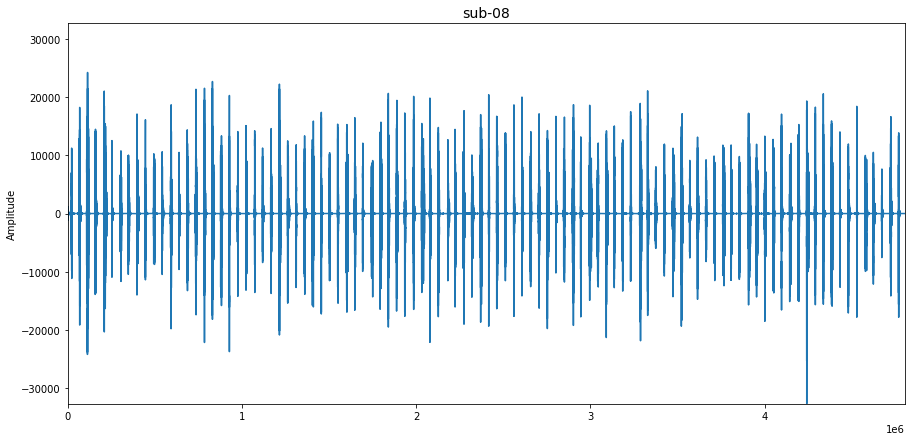

In [6]:
import os
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavefile
import scipy, numpy as np

rate, audio = wavefile.read(os.path.join(feat_path,f'{participant}_orig_audio.wav')) # example file

fig = plt.figure(figsize=(15,7))
plt.plot(audio)
plt.xlim([0,audio.shape[0]])
plt.ylim([-np.max(np.abs(audio)),np.max(np.abs(audio))])
plt.ylabel('Amplitude')
plt.title(participant, fontsize=14)
plt.show()

In [8]:
# Listen to the beginning of the original audiofile
from IPython.display import Audio

Audio(audio[:500000], rate=16000)

Length of wavefile in samples: 320000
Sampling rate: 16000
Shape of complex spectrum: (1246, 513) 



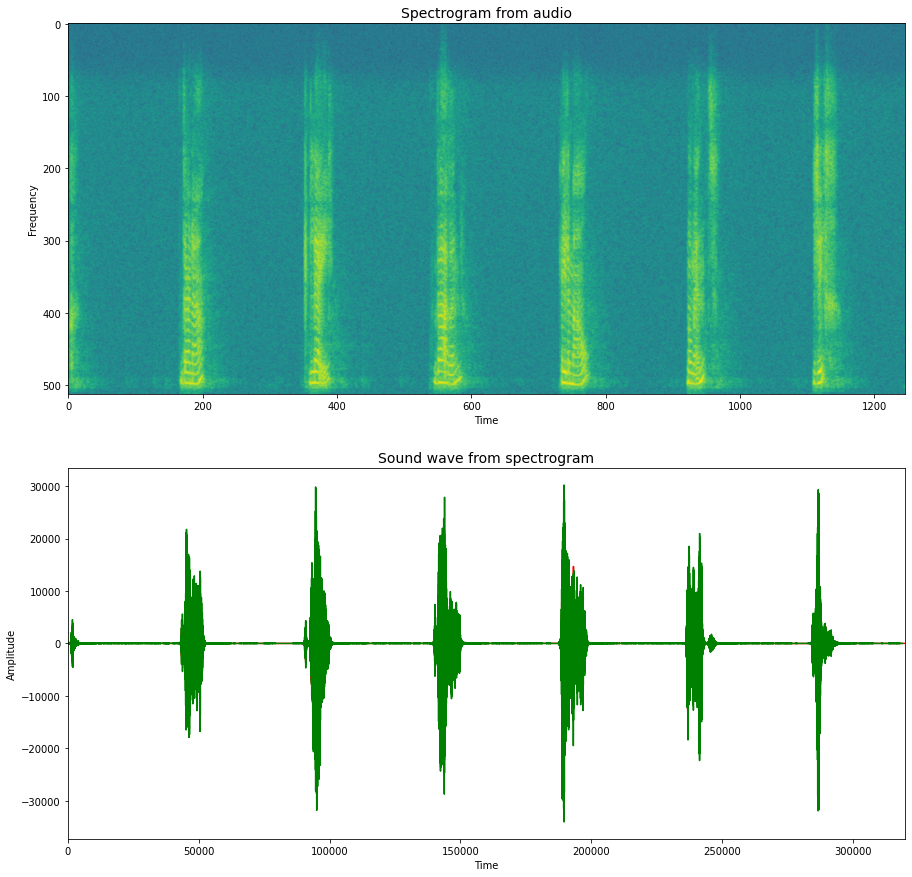

In [9]:
# Wave reconstruction

def stft(x, fftsize=1024, overlap=4):
    # Returns short time fourier transform of a signal x
    hop = int(fftsize / overlap)
    w = np.hanning(fftsize+1)[:-1]      # better reconstruction with this trick +1)[:-1]
    return np.array([np.fft.rfft(w*x[i:i+int(fftsize)]) for i in range(0, len(x)-int(fftsize), hop)])

def istft(X, overlap=4):
    #Returns inverse short time fourier transform of a complex spectrum X
    fftsize=(X.shape[1]-1)*2
    hop = int(fftsize / overlap)
    w = np.hanning(fftsize+1)[:-1]
    x = np.zeros(X.shape[0]*hop)
    wsum = np.zeros(X.shape[0]*hop)
    for n,i in enumerate(range(0, len(x)-fftsize, hop)):
        x[i:i+fftsize] += np.real(np.fft.irfft(X[n])) * w   # overlap-add
        wsum[i:i+fftsize] += w ** 2.
    return x

def reconstructWavFromSpectrogram(spec,lenWaveFile,fftsize=1024,overlap=4,numIterations=8):
    reconstructedWav = np.random.rand(lenWaveFile*2)
    for i in range(numIterations):
        x=stft(reconstructedWav,fftsize=fftsize,overlap=overlap)
        #print(str(x.shape) + '  ' + str(spec.shape))
        z=spec*np.exp(1j*np.angle(x[:spec.shape[0],:])) #[:spec.shape[0],:spec.shape[1]]
        re=istft(z,overlap=overlap)
        reconstructedWav[:len(re)]=re
    reconstructedWav=reconstructedWav[:len(re)]
    return reconstructedWav


sr, wf = wavefile.read(os.path.join(feat_path,f'{participant}_orig_audio.wav')) # example file
wf = wf[40*sr:60*sr]
print('Length of wavefile in samples: ' + str(wf.shape[0]))
print('Sampling rate: ' + str(sr))
x=stft(wf)
print('Shape of complex spectrum: ' + str(x.shape),'\n')
spectrogram=np.abs(x)

f, (ax1, ax2) = plt.subplots(2,1,figsize=(15, 15))
#ax1.matshow(np.log(spectrogram),aspect='auto')
ax1.imshow(np.flipud(np.log(spectrogram.T)), interpolation=None,aspect='auto')
ax1.set_title('Spectrogram from audio', fontsize=14)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Time')

data = reconstructWavFromSpectrogram(spectrogram,len(wf))
ax2.plot(wf,'r',data,'g')
ax2.set_xlim([0,wf.shape[0]])
ax2.set_title('Sound wave from spectrogram', fontsize=14)
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time')

plt.show()

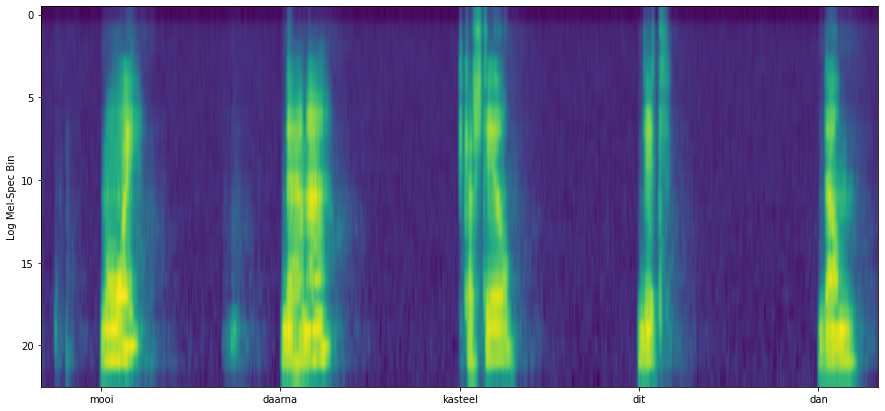

In [10]:
# Plotting spectrogram with words
participant = 'sub-04'

#Which timeframe to plot
start_s = 5.5
stop_s=19.5
frameshift = 0.01

spectrogram = np.load(os.path.join(feat_path, f'{participant}_spec.npy'))

#Load prompted words
eeg_sr= 1024
words = np.load(os.path.join(feat_path,f'{participant}_procWords.npy'))[int(start_s*eeg_sr):int(stop_s*eeg_sr)]
words = [words[w] for w in np.arange(1,len(words)) if words[w]!=words[w-1] and words[w]!='']

pSta=int(start_s/frameshift)
pSto=int(stop_s/frameshift)

fig  = plt.figure(figsize=(15,7))
plt.imshow(np.flipud(spectrogram[pSta:pSto, :].T), interpolation=None, aspect='auto')
plt.ylabel('Log Mel-Spec Bin')
plt.xticks(np.arange(int(1/frameshift),spectrogram[pSta:pSto, :].shape[0],3*int(1/frameshift)), labels=words)
plt.show()